# Functions & Imports

In [145]:
import re

In [146]:
# results folder
results_folder = 'results/'

In [147]:
def average_commit_and_abort_rate(file_path):
    """
    Parse an Aria/YCSB log that contains *10* runs and return:
        1) the mean of the 'total commit:' values
        2) the mean abort-rate across runs
           (abort-rate_i = average_abort_i / (average_commit_i + average_abort_i))
    Raises ValueError if it can’t find exactly 10 runs.
    """
    total_commits = []
    abort_rates   = []

    # e.g. "total commit: 29394"
    total_commit_re = re.compile(r'total commit:\s*([0-9.]+)')

    # e.g. "average commit: 29394 abort: 823.5 ..."
    avg_line_re = re.compile(
        r'average commit:\s*([0-9.]+)\s+abort:\s*([0-9.]+)'
    )

    with open(file_path, 'r') as f:
        for line in f:
            m_tot = total_commit_re.search(line)
            if m_tot:
                total_commits.append(float(m_tot.group(1)))
                continue            # total line never also matches avg regex

            m_avg = avg_line_re.search(line)
            if m_avg:
                commit = float(m_avg.group(1))
                abort  = float(m_avg.group(2))
                abort_rate = abort / (commit + abort) if (commit + abort) else 0
                abort_rates.append(abort_rate)

    # sanity-check: expect 10 runs
    if len(total_commits) != 10 or len(abort_rates) != 10:
        raise ValueError(
            f"Expected 10 runs, found {len(total_commits)} total-commit lines "
            f"and {len(abort_rates)} average-commit lines."
        )

    avg_commit      = sum(total_commits) / 10
    avg_abort_rate  = sum(abort_rates)  / 10    # still a fraction, e.g. 0.27

    return avg_commit, avg_abort_rate

In [148]:
import matplotlib.pyplot as plt
import os

# Assumes this function is already defined elsewhere
# from your_module import average_commit_and_abort_rate

def plot_vs_contention_level(batch_size, results_folder='./results/', contention_levels=None):
    """
    Plots throughput and abort rate vs. contention level for a fixed batch size.

    Parameters:
    - batch_size: int, e.g., 1000
    - results_folder: str, path to folder containing result .txt files
    - contention_levels: list of str, e.g., ['low_contention', 'medium_contention', 'high_contention']
    """
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention']

    throughput = []
    abort_rate = []
    labels = []

    for level in contention_levels:
        filename = f"{level}_{batch_size}.txt"
        filepath = os.path.join(results_folder, filename)
        try:
            average_commit, avg_abort_rate = average_commit_and_abort_rate(filepath)
            throughput.append(average_commit)
            abort_rate.append(avg_abort_rate * 100)  # convert to percent
            labels.append(level.replace('_contention', '').capitalize())  # Clean label for plot
            print(f"{level} - Throughput: {average_commit:.2f}, Abort Rate: {avg_abort_rate:.2%}")
        except FileNotFoundError:
            print(f"Warning: File {filepath} not found. Skipping.")
            continue

    # Plot: Throughput vs. Contention Level
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(labels, throughput, marker='o', color='blue')
    plt.title(f'Throughput vs. Contention Level\n(Batch Size {batch_size})')
    plt.xlabel('Contention Level')
    plt.ylabel('Throughput (commits/sec)')
    plt.grid(True)

    # Plot: Abort Rate vs. Contention Level
    plt.subplot(1, 2, 2)
    plt.plot(labels, abort_rate, marker='x', color='red')
    plt.title(f'Abort Rate (%) vs. Contention Level\n(Batch Size {batch_size})')
    plt.xlabel('Contention Level')
    plt.ylabel('Abort Rate (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_vs_contention_level(batch_size=1000)


In [149]:
def average_p99_latency(log_file_path):
    """
    Computes the average P99 latency across 10 runs.
    For each run:
      - Averages the P99 latency across 4 workers.
    Then:
      - Averages those 10 run-level averages to get the final value.

    Parameters:
    - log_file_path: str, path to the log file containing output from all 10 runs

    Returns:
    - float: Final average P99 latency in microseconds
    """
    run_averages = []
    current_run_latencies = []

    # Regex to match lines with worker latency
    latency_pattern = re.compile(r'Worker \d+ latency: .*?(\d+)\s+us\s+\(99%\)')

    with open(log_file_path, 'r') as f:
        for line in f:
            match = latency_pattern.search(line)
            if match:
                p99_us = int(match.group(1))
                current_run_latencies.append(p99_us)

                # When we've seen 4 workers, finish the run
                if len(current_run_latencies) == 4:
                    run_avg = sum(current_run_latencies) / 4
                    run_averages.append(run_avg)
                    current_run_latencies = []

    if len(run_averages) != 10:
        print(f"Warning: Expected 10 runs, but found {len(run_averages)}")

    final_avg = sum(run_averages) / len(run_averages) if run_averages else None
    return final_avg

In [150]:
def plot_p99_latency_vs_contention_level(
    batch_size=1000,
    contention_levels=None,
    results_folder='./results/'
):
    """
    Plots average P99 latency vs. contention level for a given batch size.

    Parameters:
    - batch_size: int, the fixed batch size for all files
    - contention_levels: list of str, e.g., ['low_contention', 'medium_contention', ...]
    - results_folder: str, base directory of result files
    """
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']

    avg_latencies = []
    labels = []

    for level in contention_levels:
        filename = f"{level}_{batch_size}.txt"
        filepath = os.path.join(results_folder, filename)
        try:
            avg_p99 = average_p99_latency(filepath)
            avg_latencies.append(avg_p99)
            labels.append(level.replace('_contention', '').capitalize())
            print(f"{level} - Average P99 latency: {avg_p99:.2f} us")
        except FileNotFoundError:
            print(f"Warning: File {filepath} not found. Skipping.")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(labels, avg_latencies, marker='o', color='darkgreen')
    plt.title(f'Average P99 Latency vs. Contention Level\n(Batch Size {batch_size})')
    plt.xlabel('Contention Level')
    plt.ylabel('Average P99 Latency (us)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Baselines

## Throughput and Abort Rate

low_contention - Throughput: 17994.12, Abort Rate: 1.48%
medium_contention - Throughput: 15738.85, Abort Rate: 15.68%
high_contention - Throughput: 12356.61, Abort Rate: 35.41%
extreme_contention - Throughput: 6782.87, Abort Rate: 65.25%


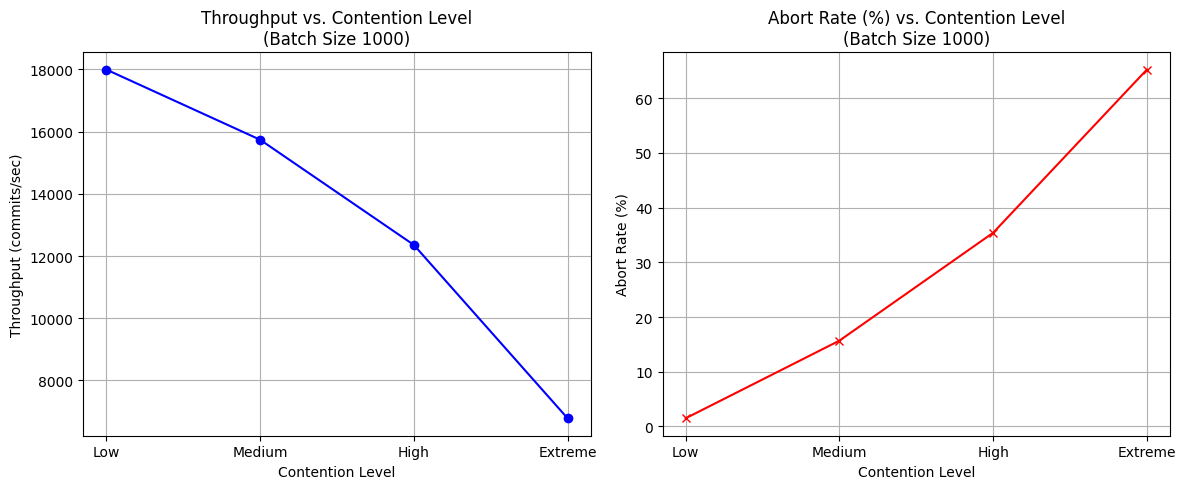

In [151]:
# e.g. expected results file: high_contention_1000.txt
plot_vs_contention_level(batch_size=1000, contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention'])


## Latency

low_contention - Average P99 latency: 142405.40 us
medium_contention - Average P99 latency: 148243.48 us
high_contention - Average P99 latency: 132536.23 us
extreme_contention - Average P99 latency: 134133.50 us


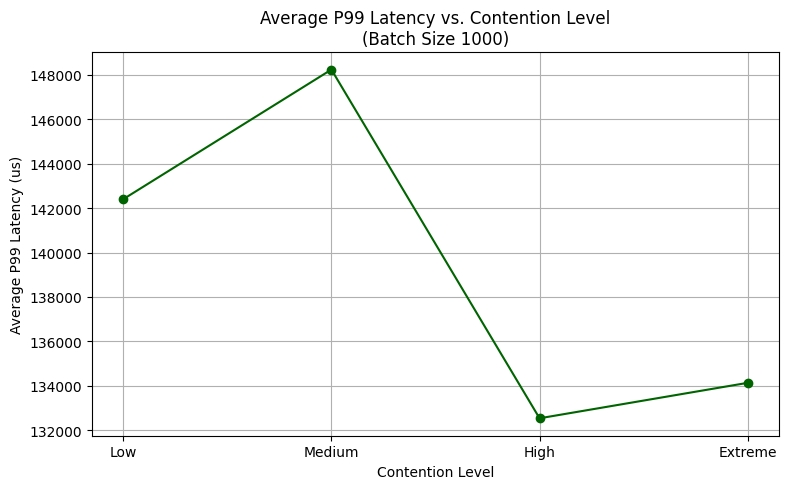

In [152]:
plot_p99_latency_vs_contention_level(
    batch_size=1000,
    contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']
)

# Testing Timed Batches (rather than txn count)
Instead of using count of transactions (e.g. 1000), use duration of execution to stop batches at a certain time. Batch size is still kept constant at 1000. If the time threshold is reached before a txn count of 1000, however, then the batch is stopped early.

## Throughput and Abort Rate

In [153]:
commit, abort_rate = average_commit_and_abort_rate(f'{results_folder}low_contention_5ms.txt')
print(f"Commit: {commit}, Abort Rate: {abort_rate:.2%}")

Commit: 19043.870000000003, Abort Rate: 1.48%


low_contention - Throughput: 19043.87, Abort Rate: 1.48%
medium_contention - Throughput: 16191.16, Abort Rate: 15.65%
high_contention - Throughput: 12375.83, Abort Rate: 35.49%
extreme_contention - Throughput: 7063.77, Abort Rate: 65.15%


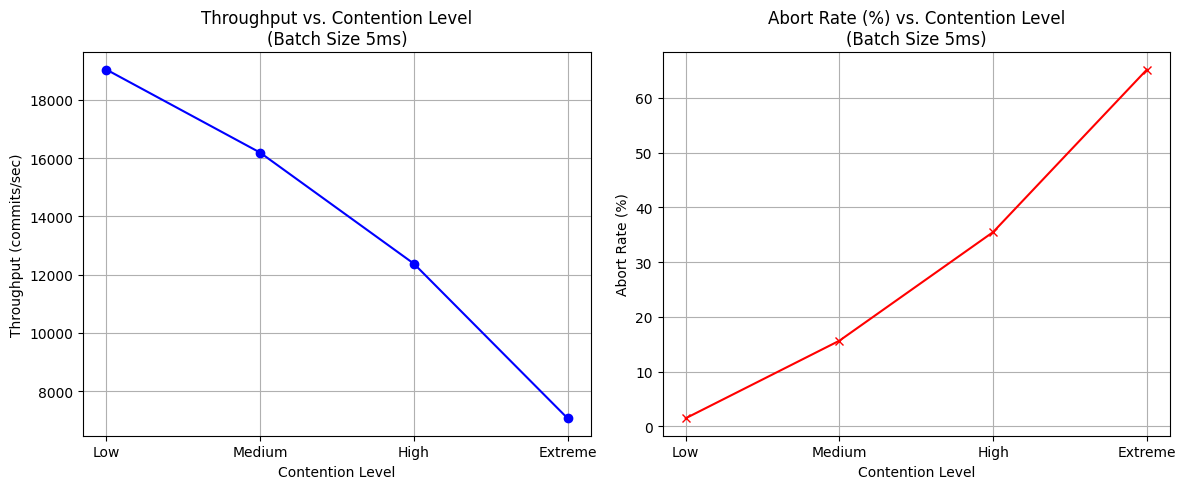

In [154]:
# e.g. expected results file: high_contention_batch_time_5ms.txt
plot_vs_contention_level(batch_size='5ms', contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention'])

## Latency

low_contention - Average P99 latency: 103198.50 us
medium_contention - Average P99 latency: 105506.93 us
high_contention - Average P99 latency: 108516.38 us
extreme_contention - Average P99 latency: 97875.70 us


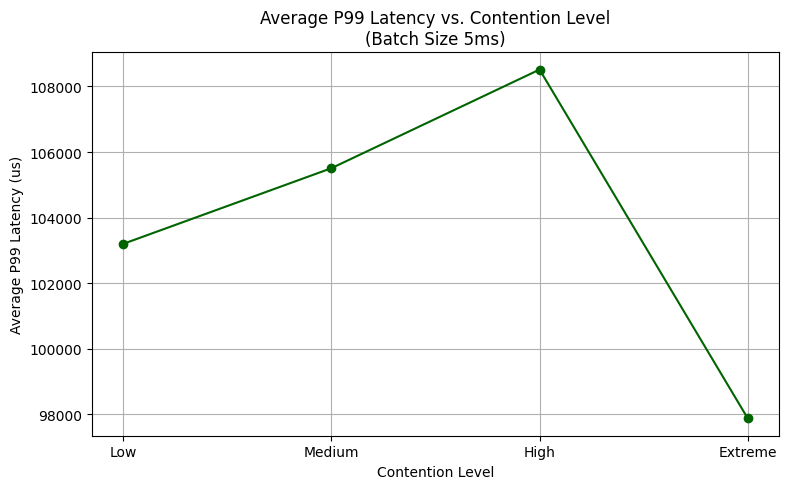

In [155]:
plot_p99_latency_vs_contention_level(
    batch_size='5ms',
    contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']
)

# Comparing Baselines to Experiments

## Functions

In [156]:

def plot_metrics_vs_contention_levels_multiple(
    batch_sizes=['1000', '5ms'],
    results_folder='./results/',
    contention_levels=None
):
    if contention_levels is None:
        contention_levels = ['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']

    x_labels = [level.replace('_contention', '').capitalize() for level in contention_levels]

    # Use 2x2 grid layout: top row for throughput + abort rate, bottom for latency
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    ax1, ax2, ax3 = axs[0, 0], axs[0, 1], axs[1, 0]
    fig.delaxes(axs[1, 1])  # remove unused bottom-right plot

    for batch_size in batch_sizes:
        throughput = []
        abort_rate = []
        latencies = []

        for level in contention_levels:
            filename = f"{level}_{batch_size}.txt"
            filepath = os.path.join(results_folder, filename)
            try:
                avg_commit, avg_abort = average_commit_and_abort_rate(filepath)
                avg_latency = average_p99_latency(filepath)
                throughput.append(avg_commit)
                abort_rate.append(avg_abort * 100)
                latencies.append(avg_latency)
                print(f"{filename} - Throughput: {avg_commit:.2f}, Abort: {avg_abort:.2%}, P99: {avg_latency:.2f} us")
            except FileNotFoundError:
                print(f"Warning: File {filepath} not found. Skipping.")
                throughput.append(None)
                abort_rate.append(None)
                latencies.append(None)

        valid = [i for i in range(len(throughput)) if throughput[i] is not None]
        x = [x_labels[i] for i in valid]
        y1 = [throughput[i] for i in valid]
        y2 = [abort_rate[i] for i in valid]
        y3 = [latencies[i] for i in valid]

        ax1.plot(x, y1, marker='o', label=f'Batch {batch_size}')
        ax2.plot(x, y2, marker='x', label=f'Batch {batch_size}')
        ax3.plot(x, y3, marker='s', label=f'Batch {batch_size}')

    # Throughput
    ax1.set_title('Throughput vs. Contention Level')
    ax1.set_xlabel('Contention Level')
    ax1.set_ylabel('Throughput (commits/sec)')
    ax1.grid(True)
    ax1.legend()

    # Abort Rate
    ax2.set_title('Abort Rate (%) vs. Contention Level')
    ax2.set_xlabel('Contention Level')
    ax2.set_ylabel('Abort Rate (%)')
    ax2.grid(True)
    ax2.legend()

    # Latency
    ax3.set_title('P99 Latency vs. Contention Level')
    ax3.set_xlabel('Contention Level')
    ax3.set_ylabel('P99 Latency (us)')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.show()


In [157]:
def plot_metrics_vs_batch_sizes(
    contention_level='medium_contention',
    batch_sizes=['1000', '5ms', '10ms'],
    results_folder='./results/'
):
    """
    Plots throughput, abort rate, and average P99 latency vs. batch size
    for a fixed contention level.

    Parameters:
    - contention_level: str, e.g., 'medium_contention'
    - batch_sizes: list of str, e.g., ['1000', '5ms', '10ms']
    - results_folder: str, base folder where result files are stored
    """
    throughput = []
    abort_rate = []
    latencies = []
    labels = batch_sizes

    for batch_size in batch_sizes:
        filename = f"{contention_level}_{batch_size}.txt"
        filepath = os.path.join(results_folder, filename)
        try:
            avg_commit, avg_abort = average_commit_and_abort_rate(filepath)
            avg_latency = average_p99_latency(filepath)
            throughput.append(avg_commit)
            abort_rate.append(avg_abort * 100)
            latencies.append(avg_latency)
            print(f"{filename} - Throughput: {avg_commit:.2f}, Abort: {avg_abort:.2%}, P99: {avg_latency:.2f} us")
        except FileNotFoundError:
            print(f"Warning: File {filepath} not found. Skipping.")
            throughput.append(None)
            abort_rate.append(None)
            latencies.append(None)

    # Filter out missing data
    valid = [i for i in range(len(throughput)) if throughput[i] is not None]
    x = [labels[i] for i in valid]
    y1 = [throughput[i] for i in valid]
    y2 = [abort_rate[i] for i in valid]
    y3 = [latencies[i] for i in valid]

    # Set up 2x2 grid with 3 plots
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    ax1, ax2, ax3 = axs[0, 0], axs[0, 1], axs[1, 0]
    fig.delaxes(axs[1, 1])  # Remove unused subplot

    # Plot throughput
    ax1.plot(x, y1, marker='o', color='blue')
    ax1.set_title(f'Throughput vs. Batch Size\n({contention_level.replace("_", " ").title()})')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Throughput (commits/sec)')
    ax1.grid(True)

    # Plot abort rate
    ax2.plot(x, y2, marker='x', color='red')
    ax2.set_title(f'Abort Rate (%) vs. Batch Size\n({contention_level.replace("_", " ").title()})')
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Abort Rate (%)')
    ax2.grid(True)

    # Plot latency
    ax3.plot(x, y3, marker='s', color='green')
    ax3.set_title(f'P99 Latency vs. Batch Size\n({contention_level.replace("_", " ").title()})')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('P99 Latency (us)')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

## Metrics vs. Contention Levels

low_contention_1000.txt - Throughput: 17994.12, Abort: 1.48%, P99: 142405.40 us
medium_contention_1000.txt - Throughput: 15738.85, Abort: 15.68%, P99: 148243.48 us
high_contention_1000.txt - Throughput: 12356.61, Abort: 35.41%, P99: 132536.23 us
extreme_contention_1000.txt - Throughput: 6782.87, Abort: 65.25%, P99: 134133.50 us
low_contention_2ms.txt - Throughput: 19877.16, Abort: 1.50%, P99: 106551.07 us
medium_contention_2ms.txt - Throughput: 16997.24, Abort: 15.67%, P99: 103353.10 us
high_contention_2ms.txt - Throughput: 12870.10, Abort: 35.46%, P99: 100181.15 us
extreme_contention_2ms.txt - Throughput: 7038.49, Abort: 65.18%, P99: 103189.98 us
low_contention_5ms.txt - Throughput: 19043.87, Abort: 1.48%, P99: 103198.50 us
medium_contention_5ms.txt - Throughput: 16191.16, Abort: 15.65%, P99: 105506.93 us
high_contention_5ms.txt - Throughput: 12375.83, Abort: 35.49%, P99: 108516.38 us
extreme_contention_5ms.txt - Throughput: 7063.77, Abort: 65.15%, P99: 97875.70 us
low_contention_10ms

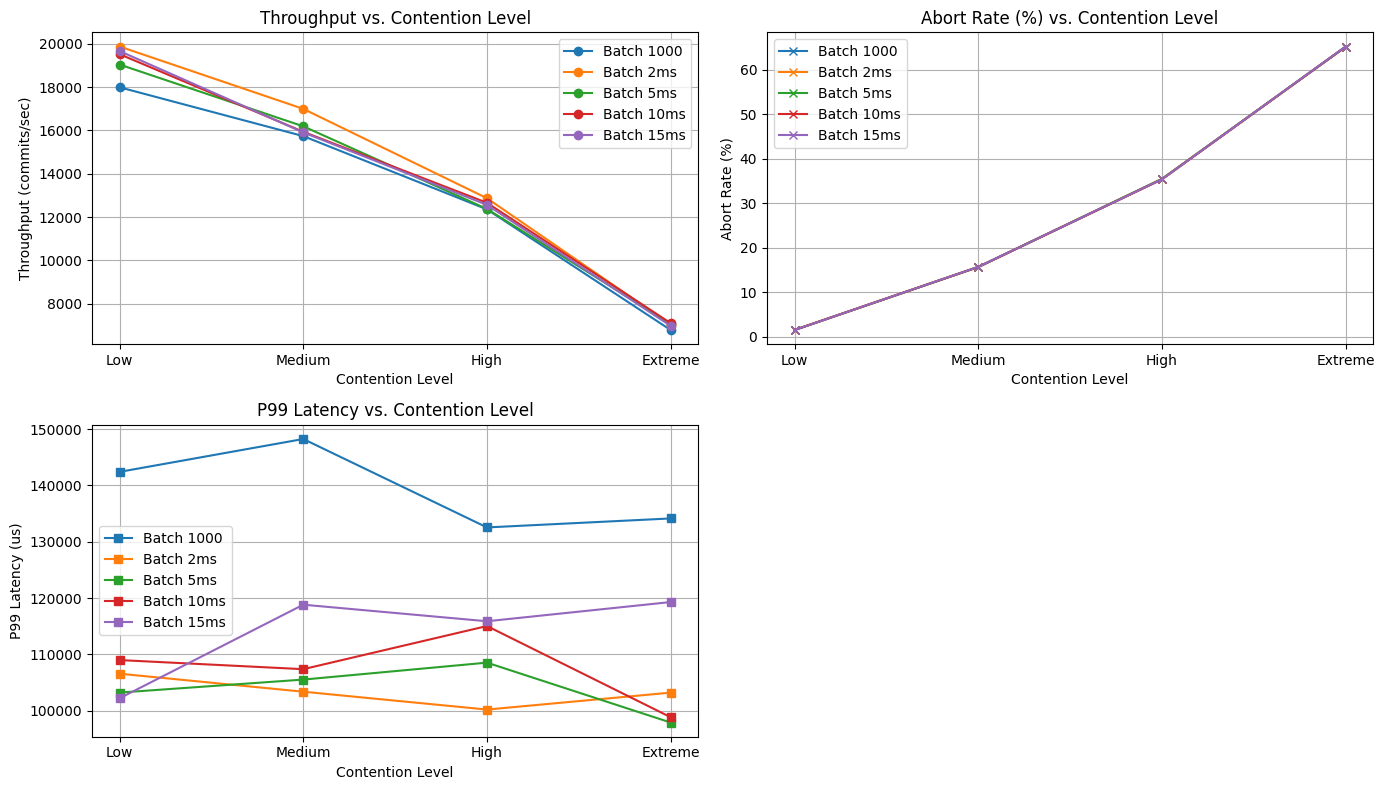

In [158]:
plot_metrics_vs_contention_levels_multiple(
    batch_sizes=['1000', '2ms', '5ms', '10ms', '15ms'],
    contention_levels=['low_contention', 'medium_contention', 'high_contention', 'extreme_contention']
)

## Metrics vs. Batch Strategy

low_contention_1000.txt - Throughput: 17994.12, Abort: 1.48%, P99: 142405.40 us
low_contention_2ms.txt - Throughput: 19877.16, Abort: 1.50%, P99: 106551.07 us
low_contention_5ms.txt - Throughput: 19043.87, Abort: 1.48%, P99: 103198.50 us
low_contention_10ms.txt - Throughput: 19521.81, Abort: 1.51%, P99: 108974.25 us
low_contention_15ms.txt - Throughput: 19666.62, Abort: 1.48%, P99: 102187.80 us


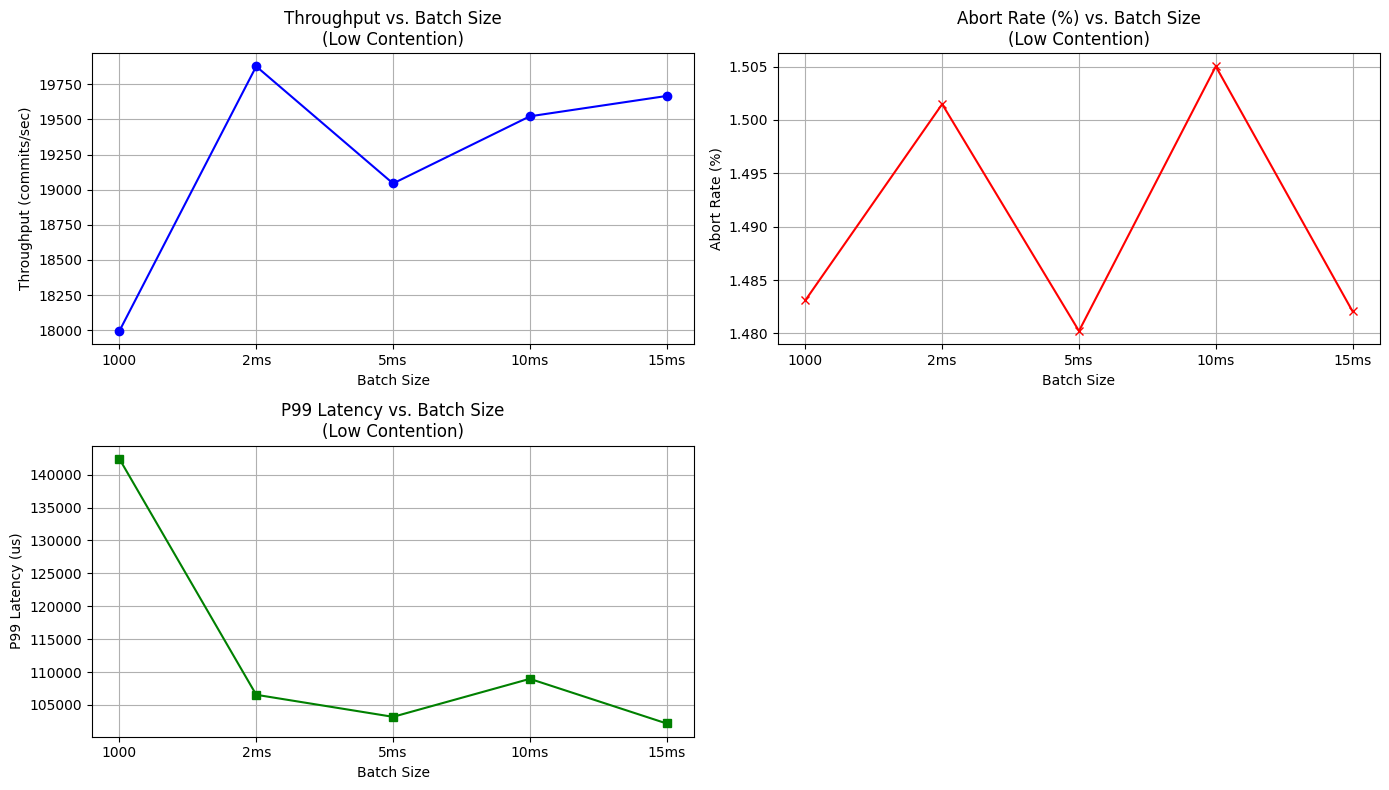

In [159]:
plot_metrics_vs_batch_sizes(
    contention_level='low_contention',
    batch_sizes=['1000', '2ms', '5ms', '10ms', '15ms']
)

medium_contention_1000.txt - Throughput: 15738.85, Abort: 15.68%, P99: 148243.48 us
medium_contention_2ms.txt - Throughput: 16997.24, Abort: 15.67%, P99: 103353.10 us
medium_contention_5ms.txt - Throughput: 16191.16, Abort: 15.65%, P99: 105506.93 us
medium_contention_10ms.txt - Throughput: 15938.05, Abort: 15.66%, P99: 107356.75 us
medium_contention_15ms.txt - Throughput: 15910.40, Abort: 15.68%, P99: 118809.15 us


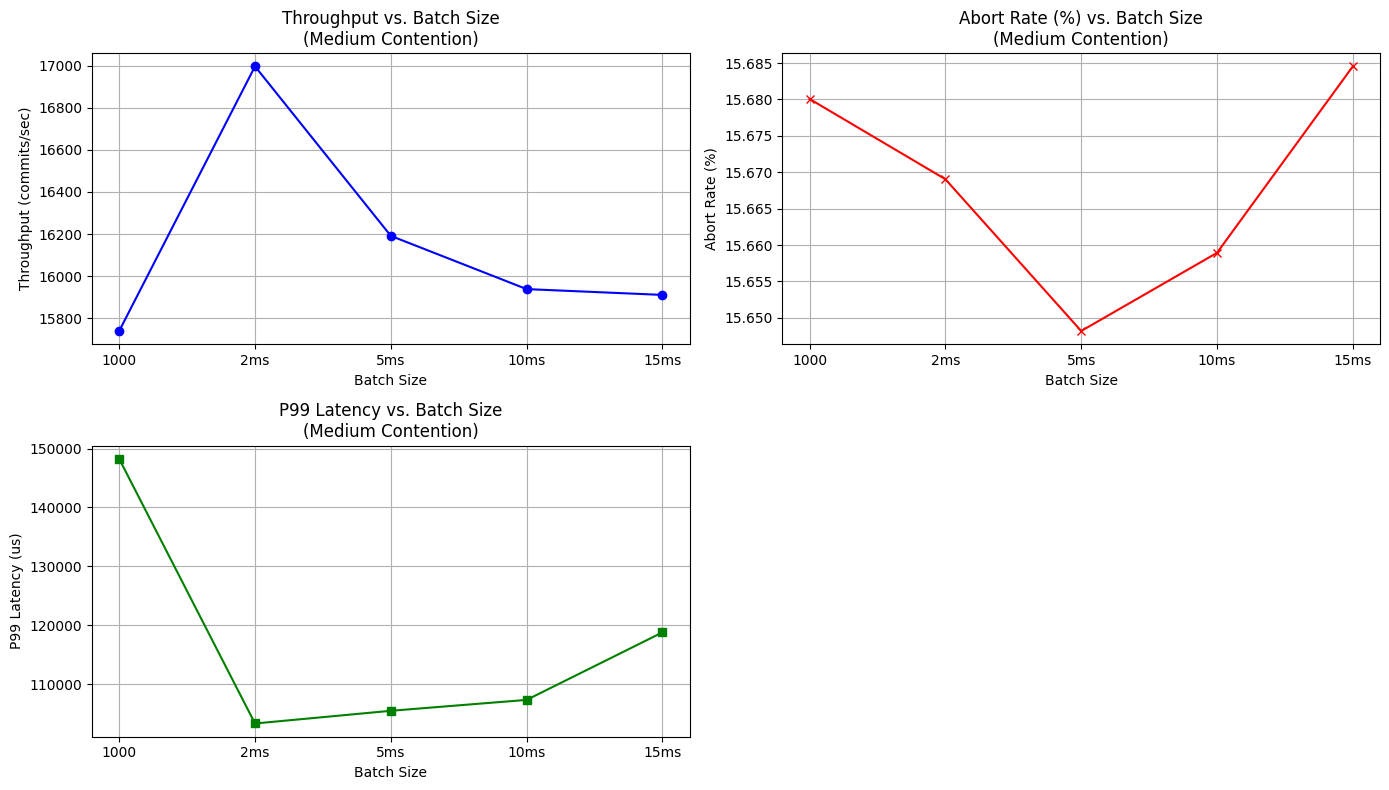

In [160]:
plot_metrics_vs_batch_sizes(
    contention_level='medium_contention',
    batch_sizes=['1000', '2ms', '5ms', '10ms', '15ms']
)

high_contention_1000.txt - Throughput: 12356.61, Abort: 35.41%, P99: 132536.23 us
high_contention_2ms.txt - Throughput: 12870.10, Abort: 35.46%, P99: 100181.15 us
high_contention_5ms.txt - Throughput: 12375.83, Abort: 35.49%, P99: 108516.38 us
high_contention_10ms.txt - Throughput: 12658.77, Abort: 35.36%, P99: 115019.88 us
high_contention_15ms.txt - Throughput: 12563.79, Abort: 35.40%, P99: 115870.15 us


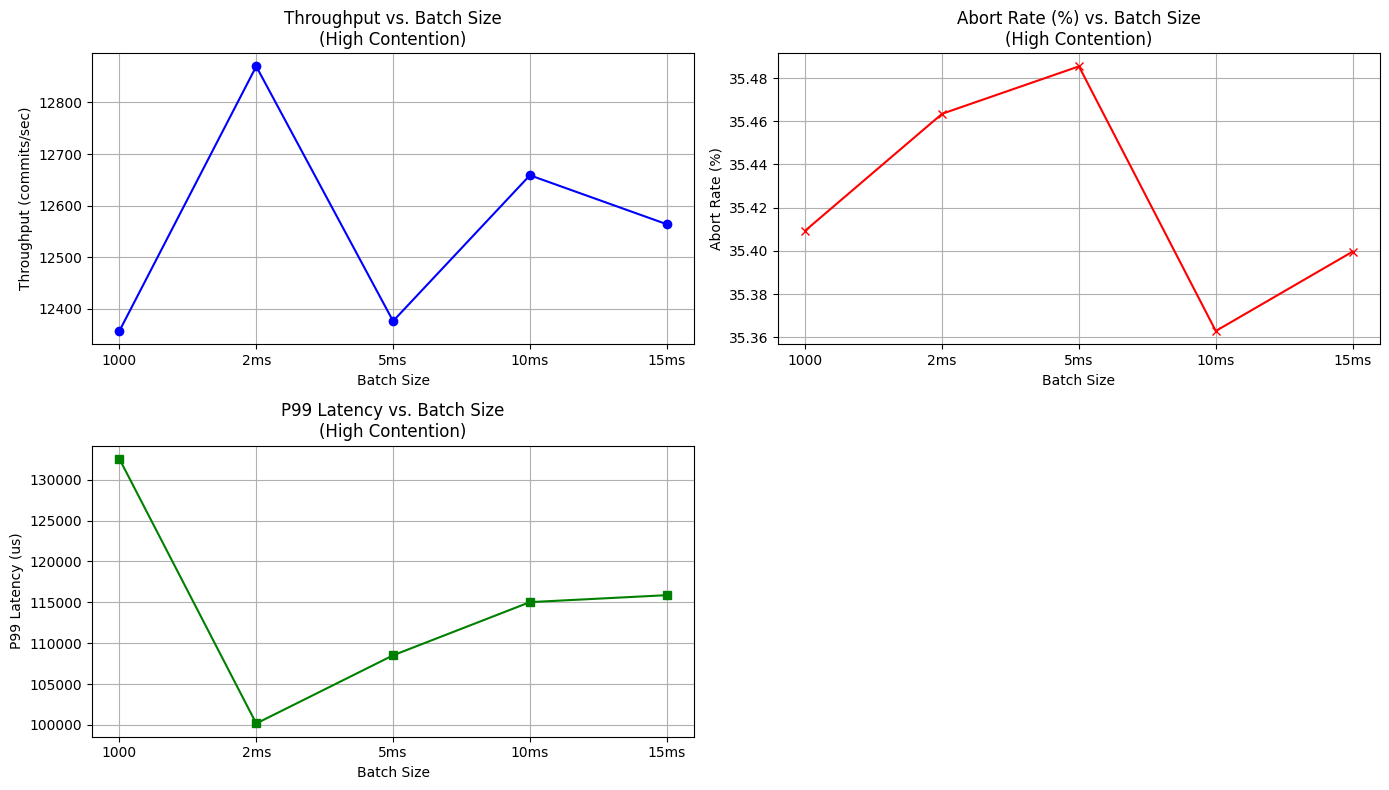

In [161]:
plot_metrics_vs_batch_sizes(
    contention_level='high_contention',
    batch_sizes=['1000', '2ms', '5ms', '10ms', '15ms']
)

extreme_contention_1000.txt - Throughput: 6782.87, Abort: 65.25%, P99: 134133.50 us
extreme_contention_2ms.txt - Throughput: 7038.49, Abort: 65.18%, P99: 103189.98 us
extreme_contention_5ms.txt - Throughput: 7063.77, Abort: 65.15%, P99: 97875.70 us
extreme_contention_10ms.txt - Throughput: 7101.22, Abort: 65.19%, P99: 98821.40 us
extreme_contention_15ms.txt - Throughput: 6974.65, Abort: 65.23%, P99: 119280.02 us


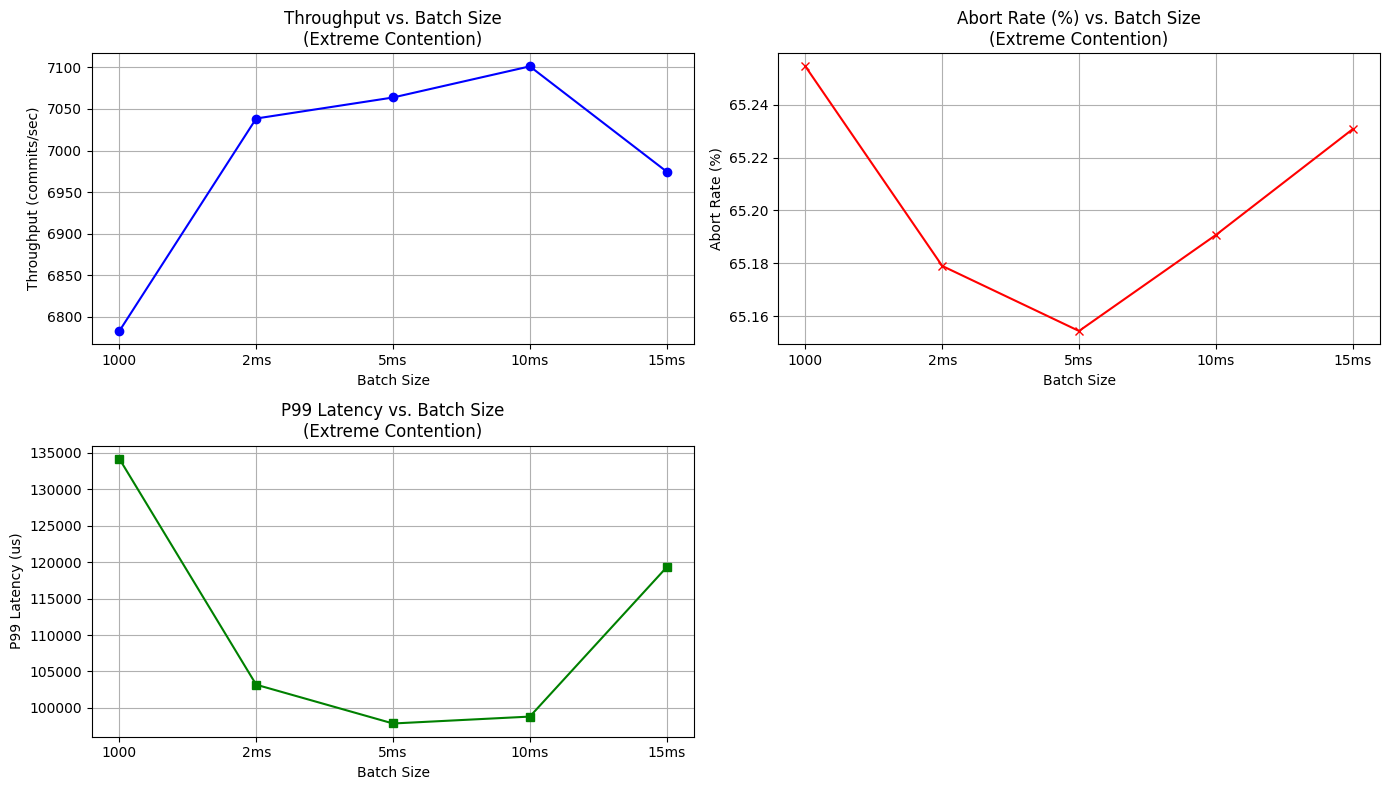

In [162]:
plot_metrics_vs_batch_sizes(
    contention_level='extreme_contention',
    batch_sizes=['1000', '2ms', '5ms', '10ms', '15ms']
)